In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [158]:
df = pd.read_csv('data/final_combined_dataset.csv')


In [159]:
df = df.drop(columns=['nearby_cases_weighted','city'])

In [160]:
df.head(10)

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,geocode,vim,vim_monthly,precipitation_avg_ordinary_kriging,precipitation_max_ordinary_kriging,precipitation_avg_regression_kriging,precipitation_max_regression_kriging,long,lat,cases_per_100k
0,2012-01-01,201201,32,207044,19.000000,79.428571,55.514486,35.000000,25.048951,29.571429,3300100,0.850500,0.852633,5.6804,18.3375,5.2038,18.7979,-44.319627,-23.009116,15.455652
1,2012-01-08,201202,40,207044,19.714286,82.285714,62.357393,47.428571,23.737513,26.571429,3300100,0.852050,0.852633,4.0716,16.5375,3.9114,16.8583,-44.319627,-23.009116,19.319565
2,2012-01-15,201203,19,207044,20.000000,83.000000,65.236264,45.571429,24.413187,28.714286,3300100,0.853541,0.852633,2.0555,5.0500,1.7556,3.1368,-44.319627,-23.009116,9.176793
3,2012-01-22,201204,33,207044,19.285714,83.000000,60.362637,43.428571,24.879121,28.857143,3300100,0.854877,0.852633,1.5416,5.7059,1.4138,5.2767,-44.319627,-23.009116,15.938641
4,2012-01-29,201205,36,207044,18.857143,80.857143,50.885924,33.142857,25.989992,30.428571,3300100,0.856021,0.852633,2.8204,9.3826,2.0057,7.8749,-44.319627,-23.009116,17.387608
5,2012-02-05,201206,39,207044,19.571429,81.571429,43.494048,22.142857,28.614927,33.571429,3300100,0.857159,0.858000,3.8170,25.9830,3.8228,26.0478,-44.319627,-23.009116,18.836576
6,2012-02-12,201207,37,207044,20.142857,80.142857,56.778911,40.571429,25.791314,29.571429,3300100,0.858241,0.858000,4.0861,29.4086,4.0920,29.0110,-44.319627,-23.009116,17.870598
7,2012-02-19,201208,33,207044,21.857143,74.000000,51.458425,34.428571,27.253296,31.285714,3300100,0.859142,0.858000,0.5962,4.0133,0.4783,3.2643,-44.319627,-23.009116,15.938641
8,2012-02-26,201209,46,207044,20.714286,80.142857,43.760989,21.285714,28.902930,34.000000,3300100,0.860082,0.858000,0.8143,3.8456,0.8171,3.8703,-44.319627,-23.009116,22.217500
9,2012-03-04,201210,42,207044,20.428571,71.714286,48.333639,28.428571,26.467491,30.857143,3300100,0.860933,0.861567,1.1867,5.3867,0.6647,3.8741,-44.319627,-23.009116,20.285543


<Axes: >

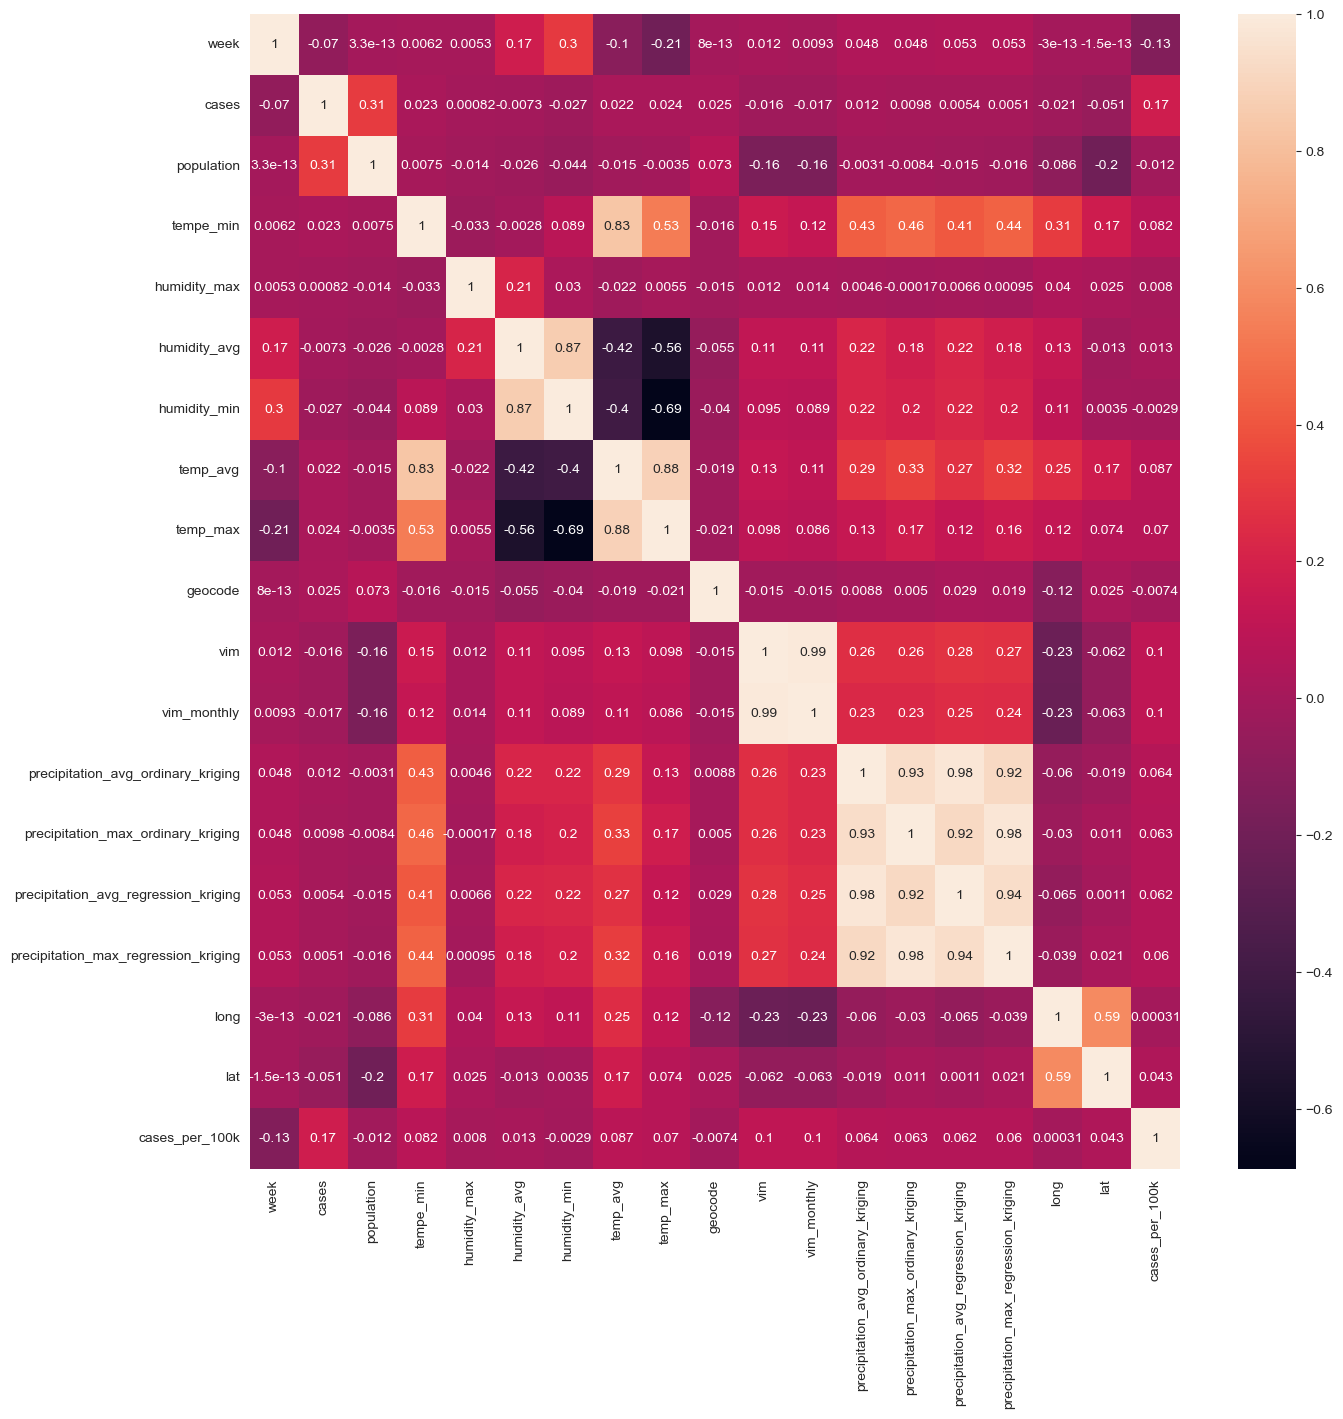

In [161]:
s = df.select_dtypes(include="number").corr()
plt.figure(figsize=(15,15))
sns.heatmap(s,annot=True)

In [162]:
df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])

ADDING CYCLIC FEATURES

In [163]:
# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52234 entries, 0 to 52233
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  52234 non-null  datetime64[ns]
 1   week                                  52234 non-null  int64         
 2   cases                                 52234 non-null  int64         
 3   population                            52234 non-null  int64         
 4   tempe_min                             52234 non-null  float64       
 5   humidity_max                          52234 non-null  float64       
 6   humidity_avg                          52234 non-null  float64       
 7   humidity_min                          52234 non-null  float64       
 8   temp_avg                              52234 non-null  float64       
 9   temp_max                              52234 non-null  float64       
 10

In [165]:
# columns = df.columns
# print(columns)
df = df[df['geocode'] == 3302205]

In [166]:
# Adding a lag feature for the previous time step (1 lag)
df['cases_lag1'] = df['cases'].shift(1)

# Adding multiple lags (e.g., 2 lags)
df['cases_lag2'] = df['cases'].shift(2)


df['cases_lag3'] = df['cases'].shift(3)

# Adding multiple lags (e.g., 2 lags)
df['cases_lag4'] = df['cases'].shift(4)

df

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,...,year,month,month_sin,month_cos,week_sin,week_cos,cases_lag1,cases_lag2,cases_lag3,cases_lag4
18368,2012-01-01,201201,18,103800,22.285714,100.000000,88.757380,66.142857,25.046922,28.571429,...,2012,1,5.000000e-01,0.866025,1.000000,7.185429e-13,NaN,NaN,NaN,NaN
18369,2012-01-08,201202,3,103800,22.571429,100.000000,83.672803,57.428571,26.392073,29.714286,...,2012,1,5.000000e-01,0.866025,0.992709,-1.205367e-01,18.0,NaN,NaN,NaN
18370,2012-01-15,201203,7,103800,22.714286,99.142857,73.477767,44.428571,27.801113,32.428571,...,2012,1,5.000000e-01,0.866025,0.970942,-2.393157e-01,3.0,18.0,NaN,NaN
18371,2012-01-22,201204,7,103800,22.571429,98.285714,73.252736,46.285714,27.280968,31.285714,...,2012,1,5.000000e-01,0.866025,0.935016,-3.546049e-01,7.0,3.0,18.0,NaN
18372,2012-01-29,201205,7,103800,22.571429,99.142857,80.105720,54.000000,26.336302,29.857143,...,2012,1,5.000000e-01,0.866025,0.885456,-4.647232e-01,7.0,7.0,3.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18937,2022-11-27,202248,37,103800,23.285714,95.027701,88.287218,81.672432,24.504762,25.714286,...,2022,11,-5.000000e-01,0.866025,0.663123,-7.485107e-01,32.0,33.0,23.0,9.0
18938,2022-12-04,202249,21,103800,23.857143,92.702140,78.166074,66.300473,25.942857,28.142857,...,2022,12,-2.449294e-16,1.000000,0.568065,-8.229839e-01,37.0,32.0,33.0,23.0
18939,2022-12-11,202250,40,103800,23.666667,92.335559,73.421199,60.245610,26.311111,28.666667,...,2022,12,-2.449294e-16,1.000000,0.464723,-8.854560e-01,21.0,37.0,32.0,33.0
18940,2022-12-18,202251,23,103800,23.000000,94.127230,87.124130,79.938507,24.675000,26.000000,...,2022,12,-2.449294e-16,1.000000,0.354605,-9.350162e-01,40.0,21.0,37.0,32.0


In [167]:
train_df = df[df['date'].dt.year <= 2020]
test_df = df[df['date'].dt.year >= 2021]

print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (470, 31)
Test set shape: (104, 31)


In [168]:
# Remove the first 4 rows from train_df
train_df = train_df.iloc[4:].reset_index(drop=True)

train_df

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,...,year,month,month_sin,month_cos,week_sin,week_cos,cases_lag1,cases_lag2,cases_lag3,cases_lag4
0,2012-01-29,201205,7,103800,22.571429,99.142857,80.105720,54.000000,26.336302,29.857143,...,2012,1,5.000000e-01,0.866025,0.885456,-0.464723,7.0,7.0,3.0,18.0
1,2012-02-05,201206,4,103800,22.857143,97.428571,70.359524,42.857143,28.291837,33.428571,...,2012,2,8.660254e-01,0.500000,0.822984,-0.568065,7.0,7.0,7.0,3.0
2,2012-02-12,201207,3,103800,23.142857,98.285714,76.815424,50.428571,27.256862,31.428571,...,2012,2,8.660254e-01,0.500000,0.748511,-0.663123,4.0,7.0,7.0,7.0
3,2012-02-19,201208,10,103800,22.857143,96.714286,70.287917,40.571429,27.810455,32.571429,...,2012,2,8.660254e-01,0.500000,0.663123,-0.748511,3.0,4.0,7.0,7.0
4,2012-02-26,201209,8,103800,22.142857,96.714286,67.650532,36.571429,28.279100,34.428571,...,2012,2,8.660254e-01,0.500000,0.568065,-0.822984,10.0,3.0,4.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,2020-11-29,202049,5,103800,23.900000,94.991583,76.975693,59.857988,26.587571,29.542857,...,2020,11,-5.000000e-01,0.866025,-0.354605,-0.935016,2.0,0.0,1.0,1.0
462,2020-12-06,202050,4,103800,24.300000,89.688978,77.869938,65.808319,26.318651,28.561905,...,2020,12,-2.449294e-16,1.000000,-0.464723,-0.885456,5.0,2.0,0.0,1.0
463,2020-12-13,202051,2,103800,24.700000,88.634238,71.922259,60.739541,27.113641,29.209524,...,2020,12,-2.449294e-16,1.000000,-0.568065,-0.822984,4.0,5.0,2.0,0.0
464,2020-12-20,202052,0,103800,25.100000,91.070363,73.893605,61.173430,26.873624,29.371429,...,2020,12,-2.449294e-16,1.000000,-0.663123,-0.748511,2.0,4.0,5.0,2.0


In [169]:
# X_train = train_df.drop(columns=['cases','geocode','cases'])
# y_train = train_df[['cases_per_100k']]

# X_test = test_df.drop(columns=['cases','geocode','cases'])
# y_test = test_df[['cases_per_100k']]

In [170]:
X_train = train_df.drop(columns=['geocode','cases_per_100k'])
y_train = train_df[['cases']]

X_test = test_df.drop(columns=['geocode','cases_per_100k'])
y_test = test_df[['cases']]

In [171]:
X_test

,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,...,year,month,month_sin,month_cos,week_sin,week_cos,cases_lag1,cases_lag2,cases_lag3,cases_lag4
18838,2021-01-03,202101,2,103800,25.142857,87.833307,69.141114,58.314221,28.803031,31.285714,...,2021,1,5.000000e-01,0.866025,-0.354605,-0.935016,0.0,0.0,2.0,4.0
18839,2021-01-10,202102,2,103800,25.714286,79.427573,61.212876,52.005406,29.069913,30.857143,...,2021,1,5.000000e-01,0.866025,-0.464723,-0.885456,2.0,0.0,0.0,2.0
18840,2021-01-17,202103,0,103800,25.000000,77.547956,54.966770,44.227992,29.422078,31.285714,...,2021,1,5.000000e-01,0.866025,-0.568065,-0.822984,2.0,2.0,0.0,0.0
18841,2021-01-24,202104,4,103800,25.428571,72.793804,52.921443,43.788466,29.850433,32.000000,...,2021,1,5.000000e-01,0.866025,-0.663123,-0.748511,0.0,2.0,2.0,0.0
18842,2021-01-31,202105,0,103800,24.714286,79.501961,62.204329,48.864646,28.551948,30.714286,...,2021,1,5.000000e-01,0.866025,-0.748511,-0.663123,4.0,0.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18937,2022-11-27,202248,37,103800,23.285714,95.027701,88.287218,81.672432,24.504762,25.714286,...,2022,11,-5.000000e-01,0.866025,0.663123,-0.748511,32.0,33.0,23.0,9.0
18938,2022-12-04,202249,21,103800,23.857143,92.702140,78.166074,66.300473,25.942857,28.142857,...,2022,12,-2.449294e-16,1.000000,0.568065,-0.822984,37.0,32.0,33.0,23.0
18939,2022-12-11,202250,40,103800,23.666667,92.335559,73.421199,60.245610,26.311111,28.666667,...,2022,12,-2.449294e-16,1.000000,0.464723,-0.885456,21.0,37.0,32.0,33.0
18940,2022-12-18,202251,23,103800,23.000000,94.127230,87.124130,79.938507,24.675000,26.000000,...,2022,12,-2.449294e-16,1.000000,0.354605,-0.935016,40.0,21.0,37.0,32.0


In [172]:
df = df.drop(columns=['date','geocode','cases_per_100k'])

In [173]:
from sklearn.preprocessing import MinMaxScaler

# Exclude columns_to_scale and the target variable from scaling
columns_to_scale = ['week_sin', 'week_cos', 'month_sin', 'month_cos', 'week']
numeric_cols = [
    col for col in df.select_dtypes(include=['float64', 'int64', 'int32']).columns 
    if col not in ['cases'] + columns_to_scale
]

# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Scale the selected numeric features
X_train[numeric_cols] = feature_scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = feature_scaler.transform(X_test[numeric_cols])

# Scale the target variable
y_train = target_scaler.fit_transform(y_train)
y_test = target_scaler.transform(y_test)

# Verify the scaling



In [174]:
X_train.head(70)


,date,week,cases,population,tempe_min,humidity_max,humidity_avg,humidity_min,temp_avg,temp_max,...,year,month,month_sin,month_cos,week_sin,week_cos,cases_lag1,cases_lag2,cases_lag3,cases_lag4
0,2012-01-29,201205,7,0.0,0.652778,0.959737,0.553469,0.362319,0.678541,0.638225,...,0.000,0.000000,0.500000,0.866025,8.854560e-01,-0.464723,0.011745,0.011745,0.005034,0.030201
1,2012-02-05,201206,4,0.0,0.680556,0.879210,0.310264,0.200828,0.813440,0.808874,...,0.000,0.090909,0.866025,0.500000,8.229839e-01,-0.568065,0.011745,0.011745,0.011745,0.005034
2,2012-02-12,201207,3,0.0,0.708333,0.919473,0.471364,0.310559,0.742044,0.713311,...,0.000,0.090909,0.866025,0.500000,7.485107e-01,-0.663123,0.006711,0.011745,0.011745,0.011745
3,2012-02-19,201208,10,0.0,0.680556,0.845657,0.308477,0.167702,0.780233,0.767918,...,0.000,0.090909,0.866025,0.500000,6.631227e-01,-0.748511,0.005034,0.006711,0.011745,0.011745
4,2012-02-26,201209,8,0.0,0.611111,0.845657,0.242665,0.109731,0.812561,0.856655,...,0.000,0.090909,0.866025,0.500000,5.680647e-01,-0.822984,0.016779,0.005034,0.006711,0.011745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,2013-04-28,201318,184,0.0,0.388889,0.959737,0.391924,0.227743,0.610878,0.658703,...,0.125,0.272727,0.866025,-0.500000,1.960767e-12,-1.000000,0.300336,0.370805,0.489933,0.429530
66,2013-05-05,201319,118,0.0,0.263889,0.758419,0.281814,0.173913,0.487130,0.590444,...,0.125,0.363636,0.500000,-0.866025,-1.205367e-01,-0.992709,0.308725,0.300336,0.370805,0.489933
67,2013-05-12,201320,125,0.0,0.402778,1.000000,0.590180,0.397516,0.545504,0.604096,...,0.125,0.363636,0.500000,-0.866025,-2.393157e-01,-0.970942,0.197987,0.308725,0.300336,0.370805
68,2013-05-19,201321,69,0.0,0.375000,0.919473,0.546384,0.372671,0.424717,0.488055,...,0.125,0.363636,0.500000,-0.866025,-3.546049e-01,-0.935016,0.209732,0.197987,0.308725,0.300336


In [175]:
print("X_train shape before reshape:", X_train.shape)
print("y_train shape before reshape:", y_train.shape)


X_train shape before reshape: (466, 29)
y_train shape before reshape: (466, 1)


In [176]:
# import matplotlib.pyplot as plt
# import pandas as pd

# feature_cols = [
#      'temp_avg', 'humidity_avg','cases_lag_1','cases_lag_2','cases_lag_3','cases_lag_4',
#     'precipitation_max_regression_kriging','week_sin','week_cos','month_sin','month_cos'
    
# ]

# train_combined = X_train.copy()
# train_combined['cases_per_100k'] = y_train.flatten()  # Assuming y_train is reshaped after scaling

# # Ensure week is part of the DataFrame
# train_combined['week'] = train_df['week']

# # Group by week and calculate mean for the target variable and selected features
# weekly_data = train_combined.groupby('week')[['cases_per_100k'] + feature_cols].mean()

# # Plotting
# # plt.figure(figsize=(15, 10))
# for feature in feature_cols:
#     plt.figure(figsize=(15, 10))
#     plt.plot(
#         weekly_data.index, 
#         weekly_data[feature], 
#         label=f"{feature} (Feature)"
#     )
#     plt.plot(
#         weekly_data.index, 
#         weekly_data['cases_per_100k'], 
#         label="Cases", 
#         linestyle='--'
#     )
#     plt.xlabel("Week")
#     plt.ylabel("Scaled Value")
#     plt.title(f"Cases vs {feature} Across Weeks")
#     plt.legend()
#     plt.grid()
#     plt.show()


In [177]:
# Feature columns you want to select
feature_cols = [
     'temp_avg', 'humidity_avg','cases_lag1','cases_lag2',
    'precipitation_max_regression_kriging','week_sin','week_cos','month_sin','month_cos'
    
]

# Selecting only the desired columns from X_train and X_test
X_train = X_train[feature_cols]
X_test = X_test[feature_cols]

# Verify the new shapes
print("X_train_selected shape:", X_train.shape)
print("X_test_selected shape:", X_test.shape)


X_train_selected shape: (466, 9)
X_test_selected shape: (104, 9)


In [178]:
import numpy as np

# Function to create overlapping sequences
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length].values)  # Select seq_length rows as input
        y.append(target[i + seq_length])  # Select the next row as the target
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 4

# Create sequences for training
X_train, y_train = create_sequences(X_train, y_train, seq_length)

# Create sequences for testing
X_test, y_test = create_sequences(X_test, y_test, seq_length)

# Print the shapes to verify
print("X_train shape:", X_train.shape)  # (samples, timesteps, features)
print("y_train shape:", y_train.shape)  # (samples,)
print("X_test shape:", X_test.shape)    # (samples, timesteps, features)
print("y_test shape:", y_test.shape)    # (samples,)

X_train shape: (462, 4, 9)
y_train shape: (462, 1)
X_test shape: (100, 4, 9)
y_test shape: (100, 1)


In [179]:
# import numpy as np

# def create_sequences(data, target, seq_length):
#     X = []
#     y = []
#     for i in range(len(data) - seq_length):
#         X.append(data.iloc[i:i + seq_length].values)  # Select seq_length rows as input
#         y.append(target.iloc[i + seq_length])  # Select the next row as the target
#     return np.array(X),np.array(y)

# # Define sequence length
# seq_length = 4

# # Create sequences for training
# X_train, y_train = create_sequences(X_train, y_train, seq_length)

# # Create sequences for testing
# X_test, y_test = create_sequences(X_test, y_test, seq_length)

# # Print the shapes to verify
# print("X_train shape:", X_train.shape)  # (samples, timesteps, features)
# print("y_train shape:", y_train.shape)  # (samples,)
# print("X_test shape:", X_test.shape)    # (samples, timesteps, features)
# print("y_test shape:", y_test.shape)    # (samples,)

In [180]:


# Define sequence length for LSTM
seq_length = 4


# Build the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, len(feature_cols))),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Predicting a single value (cases)
])

# Compile the model
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Save the model
model.save("lstm_dengue_prediction_model.h5")

# Predict on test data
predictions = model.predict(X_test)


Epoch 1/50


C:\Users\ASUS\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0298 - mae: 0.0921 - val_loss: 0.0049 - val_mae: 0.0609
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0164 - mae: 0.0742 - val_loss: 0.0025 - val_mae: 0.0394
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0121 - mae: 0.0597 - val_loss: 0.0030 - val_mae: 0.0423
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0110 - mae: 0.0565 - val_loss: 0.0024 - val_mae: 0.0391
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0127 - mae: 0.0574 - val_loss: 0.0017 - val_mae: 0.0327
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0080 - mae: 0.0425 - val_loss: 0.0017 - val_mae: 0.0328
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - mae: 0.0435 - val_loss: 0.0025 - val_mae: 0.0422
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0109 - mae: 0.0502 - val_loss: 0.0018 - val_mae: 0.0352
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0094 - mae: 0.0452 - 

Test Loss: 0.004721267148852348, Test MAE: 0.0483124814927578
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


In [181]:
predictions_original_scale = target_scaler.inverse_transform(predictions)
print(predictions_original_scale)

[[-2.1541058e+01]
 [-2.3922277e+01]
 [-2.3070932e+01]
 [-1.9675602e+01]
 [-1.7600801e+01]
 [-2.0141628e+01]
 [-1.8922054e+01]
 [-1.7743618e+01]
 [-1.8190079e+01]
 [-1.5667490e+01]
 [-1.3417674e+01]
 [-8.6764717e+00]
 [-4.0222311e+00]
 [-5.9303492e-03]
 [ 3.6762259e+00]
 [ 7.8466449e+00]
 [ 9.6906595e+00]
 [ 9.1027822e+00]
 [ 8.8299618e+00]
 [ 1.1582743e+01]
 [ 1.1507087e+01]
 [ 8.4533520e+00]
 [ 5.6273375e+00]
 [ 5.2971582e+00]
 [ 4.7502117e+00]
 [ 4.5876880e+00]
 [ 1.2359905e+00]
 [-3.6270514e+00]
 [-8.8379879e+00]
 [-1.2080288e+01]
 [-1.3207440e+01]
 [-1.2368577e+01]
 [-1.3138603e+01]
 [-9.5181904e+00]
 [-8.2204590e+00]
 [ 1.1213444e+00]
 [ 8.7158813e+00]
 [ 1.7635983e+01]
 [ 1.5457841e+01]
 [ 3.1469952e+01]
 [ 2.5959423e+01]
 [ 4.0062336e+01]
 [ 6.5101135e+01]
 [ 7.2270683e+01]
 [ 7.6076843e+01]
 [ 5.9625938e+01]
 [ 3.4920307e+01]
 [ 4.9235668e+01]
 [ 4.2337978e+01]
 [ 2.3842926e+01]
 [ 1.5129083e+01]
 [ 6.6749401e+00]
 [ 3.6568608e+00]
 [-3.0159035e+00]
 [-1.7241339e+01]
 [-1.75931

Actual Values Shape: (100,)
Predicted Values Shape: (100,)


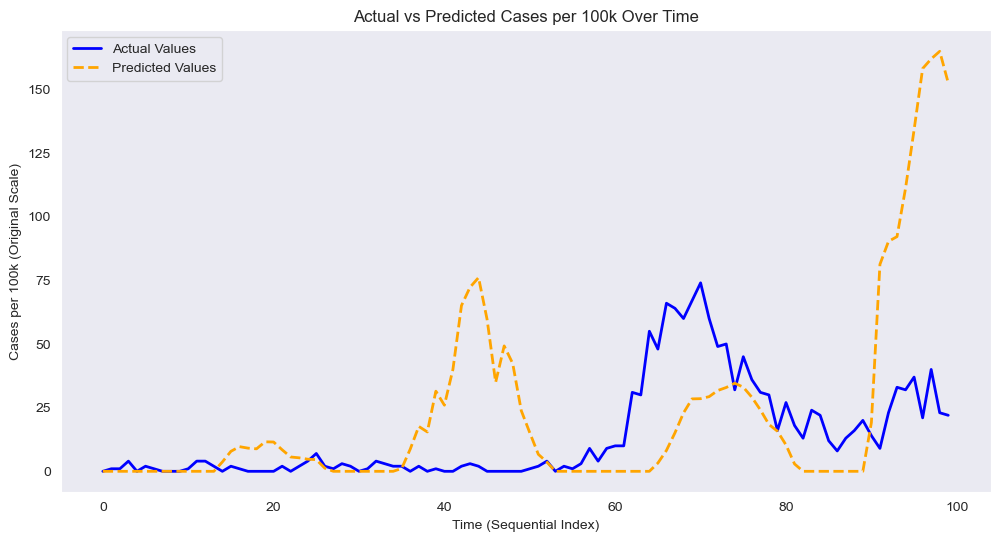

In [182]:
import matplotlib.pyplot as plt
import numpy as np

actual_values_original_scale = target_scaler.inverse_transform(y_test)
# Create a sequential index for the x-axis (as a proxy for time)
time_index = np.arange(len(actual_values_original_scale))

# Flatten actual and predicted values for plotting
actual_values_original_scale = actual_values_original_scale.flatten()
predictions_original_scale = predictions_original_scale.flatten()
predictions_original_scale[predictions_original_scale < 0] = 0

# shapes
print("Actual Values Shape:", actual_values_original_scale.shape)
print("Predicted Values Shape:", predictions_original_scale.shape)

# Plot Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(time_index, actual_values_original_scale, label="Actual Values", color='blue', linewidth=2)
plt.plot(time_index, predictions_original_scale, label="Predicted Values", color='orange', linewidth=2, linestyle='--')
plt.xlabel("Time (Sequential Index)")
plt.ylabel("Cases per 100k (Original Scale)")
plt.title("Actual vs Predicted Cases per 100k Over Time")
plt.legend()
plt.grid()
plt.show()